Importing Libraries

In [2]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import glob
import os

Defining Function

In [3]:
def extract_features(df, temp_columns, time_column='TimeStr'):
    n_rows = len(df)

    result_rows = []
    i = 0

    while i < n_rows:
        start_time = df.loc[i, time_column]
        # Find all points within 1 hour of start_time
        window_mask = (df[time_column] > start_time) & (df[time_column] <= start_time + pd.Timedelta(hours=1))
        window_indices = df.index[window_mask]

        # If no points within 1 hour, take the next available row as the “end”
        if len(window_indices) == 0:
            window_indices = [i]
            cut_short = True
        else:
            cut_short = False

        # Collect series for this window
        row_features = {'Time': start_time, 'cut_short': cut_short}

        for col in temp_columns:
            series = df.loc[i:window_indices[-1], col].dropna()
            if len(series) == 0:
                continue

            # Statistical features
            row_features[f'{col}_mean'] = series.mean()
            row_features[f'{col}_median'] = series.median()
            row_features[f'{col}_variance'] = series.var()
            row_features[f'{col}_skewness'] = skew(series) if series.var() > 0 else 0.0
            row_features[f'{col}_kurtosis'] = kurtosis(series) if series.var() > 0 else 0.0
            row_features[f'{col}_rolling_mean_3'] = series.rolling(3, min_periods=1).mean().iloc[-1]
            row_features[f'{col}_rolling_std_3'] = series.rolling(3, min_periods=1).std().iloc[-1]

            # Shape-based features
            peaks, _ = find_peaks(series)
            row_features[f'{col}_num_peaks'] = len(peaks)
            row_features[f'{col}_max_slope'] = np.max(np.abs(np.diff(series))) if len(series) > 1 else 0.0

            # Domain-specific
            if len(series) > 1:
                diffs = np.diff(series)
                row_features[f'{col}_heating_rate_max'] = np.max(diffs)
                row_features[f'{col}_cooling_rate_max'] = np.min(diffs)
            else:
                row_features[f'{col}_heating_rate_max'] = 0.0
                row_features[f'{col}_cooling_rate_max'] = 0.0
            row_features[f'{col}_duration_above_mean'] = np.sum(series > series.mean())
            row_features[f'{col}_duration_below_mean'] = np.sum(series < series.mean())

            # Frequency domain
            if len(series) > 1 and len(np.unique(series)) > 1:
                n = len(series)
                fft_values = np.abs(fft(series))
                fft_values[0] = 0
                total_energy = np.sum(fft_values**2)
                sum_fft = np.sum(fft_values)
                freqs = fftfreq(n, d=1)
                
                row_features[f'{col}_dominant_freq'] = freqs[np.argmax(fft_values)]
                row_features[f'{col}_spectral_energy'] = total_energy
                row_features[f'{col}_spectral_centroid'] = np.sum(freqs * fft_values) / sum_fft if sum_fft != 0 else 0.0
                fft_prob = fft_values / sum_fft if sum_fft != 0 else np.zeros_like(fft_values)
                row_features[f'{col}_spectral_entropy'] = -np.sum(fft_prob * np.log(fft_prob + 1e-12))
            else:
                row_features[f'{col}_dominant_freq'] = 0.0
                row_features[f'{col}_spectral_energy'] = 0.0
                row_features[f'{col}_spectral_centroid'] = 0.0
                row_features[f'{col}_spectral_entropy'] = 0.0

        result_rows.append(row_features)

        # Move i to the row **after the last row included in the window**
        i = window_indices[-1] + 1

    return pd.DataFrame(result_rows)


In [4]:
def extract_features_by_indices(df, temp_columns, gap_indices, time_column='TimeStr'):
    """
    Extract features from intervals defined by a list of gap indices.
    Much faster: slices df only once per interval, then loops over columns.
    """
    result_rows = []
    eps = 1e-8

    # Build the list of (start, end) intervals
    intervals = []
    for i in range(len(gap_indices)):
        start = gap_indices[i] + 1
        if i + 1 < len(gap_indices):
            end = gap_indices[i + 1]
        else:
            end = len(df)
        if start < end:
            intervals.append((start, end))

    for start, end in intervals:
        segment = df.iloc[start:end]  # slice once
        row_features = {
            'segment_start_time': segment[time_column].iloc[0],
            'segment_end_time': segment[time_column].iloc[-1],
            'segment_start_idx': start,
            'segment_end_idx': end - 1,
        }

        for col in temp_columns:
            series = segment[col].dropna()
            if len(series) == 0:
                continue

            # Statistical features
            row_features[f'{col}_mean'] = series.mean()
            row_features[f'{col}_median'] = series.median()
            row_features[f'{col}_variance'] = series.var()
            if series.var() > eps:
                row_features[f'{col}_skewness'] = skew(series)
                row_features[f'{col}_kurtosis'] = kurtosis(series)
            else:
                row_features[f'{col}_skewness'] = 0.0
                row_features[f'{col}_kurtosis'] = 0.0
            row_features[f'{col}_rolling_mean_3'] = series.rolling(3, min_periods=1).mean().iloc[-1]
            row_features[f'{col}_rolling_std_3'] = series.rolling(3, min_periods=1).std().iloc[-1]

            # Shape-based
            peaks, _ = find_peaks(series)
            row_features[f'{col}_num_peaks'] = len(peaks)
            row_features[f'{col}_max_slope'] = np.max(np.abs(np.diff(series))) if len(series) > 1 else 0.0

            # Domain-specific
            if len(series) > 1:
                diffs = np.diff(series)
                row_features[f'{col}_heating_rate_max'] = np.max(diffs)
                row_features[f'{col}_cooling_rate_max'] = np.min(diffs)
            else:
                row_features[f'{col}_heating_rate_max'] = 0.0
                row_features[f'{col}_cooling_rate_max'] = 0.0
            row_features[f'{col}_duration_above_mean'] = np.sum(series > series.mean())
            row_features[f'{col}_duration_below_mean'] = np.sum(series < series.mean())

            # Frequency domain
            if len(series) > 1 and len(np.unique(series)) > 1:
                n = len(series)
                fft_values = np.abs(fft(series))
                fft_values[0] = 0
                total_energy = np.sum(fft_values**2)
                sum_fft = np.sum(fft_values)
                freqs = fftfreq(n, d=1)

                row_features[f'{col}_dominant_freq'] = freqs[np.argmax(fft_values)]
                row_features[f'{col}_spectral_energy'] = total_energy
                row_features[f'{col}_spectral_centroid'] = (
                    np.sum(freqs * fft_values) / sum_fft if sum_fft != 0 else 0.0
                )
                fft_prob = fft_values / sum_fft if sum_fft != 0 else np.zeros_like(fft_values)
                row_features[f'{col}_spectral_entropy'] = -np.sum(fft_prob * np.log(fft_prob + 1e-12))
            else:
                row_features[f'{col}_dominant_freq'] = 0.0
                row_features[f'{col}_spectral_energy'] = 0.0
                row_features[f'{col}_spectral_centroid'] = 0.0
                row_features[f'{col}_spectral_entropy'] = 0.0

        result_rows.append(row_features)

    return pd.DataFrame(result_rows)


Loading Data

In [5]:
temps_df = pd.read_feather('Temps_complete.feather')
SVRM2_drive_df = pd.read_feather('SVRM2_drive_complete.feather')
SVRM3_drive_df = pd.read_feather('SVRM3_drive_complete.feather')
SVRM3_ewon_df = pd.read_feather('SVRM3_ewon_complete.feather')
SVRM4_ewon_df = pd.read_feather('SVRM4_ewon_complete.feather')

Filtering

In [6]:
temps_df = temps_df.replace(["Undef", np.nan, None], np.nan)
temps_df['TimeStr'] = pd.to_datetime(temps_df['TimeStr'], errors='coerce')
temps_df = temps_df.sort_values('TimeStr')
temps_df = temps_df.iloc[1:]
temp_columns = ['33-1-Olie', '34-2-V-O-O','35-3-V-O-B', '36-4-V-B-O', 
                '37-5-V-B-B', '38-6-WIS-O', '39-7-WIS-B','40-8-OMG']
temps_df[temp_columns] = temps_df[temp_columns].astype(float)
temps_df = temps_df.dropna(subset=temp_columns)
temps_df = temps_df.reset_index(drop=True)

(array([20332., 20333., 20334., 20335., 20336., 20337., 20338., 20339.,
        20340.]),
 [Text(20332.0, 0, '2025-09-01'),
  Text(20333.0, 0, '2025-09-02'),
  Text(20334.0, 0, '2025-09-03'),
  Text(20335.0, 0, '2025-09-04'),
  Text(20336.0, 0, '2025-09-05'),
  Text(20337.0, 0, '2025-09-06'),
  Text(20338.0, 0, '2025-09-07'),
  Text(20339.0, 0, '2025-09-08'),
  Text(20340.0, 0, '2025-09-09')])

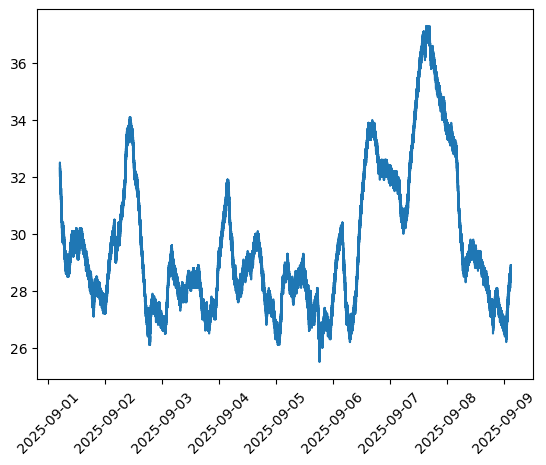

In [7]:
plt.figure()
plt.plot(temps_df['TimeStr'][207900:-1], temps_df['34-2-V-O-O'][207900:-1])
plt.xticks(rotation=45)

The machine turns off every now and then.

570 breaks of 6 seconds in length. with 15 more breaks of varying lengths.


(array([20332.125     , 20332.13541667, 20332.14583333, 20332.15625   ,
        20332.16666667, 20332.17708333, 20332.1875    , 20332.19791667,
        20332.20833333]),
 [Text(20332.125, 0, '01 03:00'),
  Text(20332.135416666668, 0, '01 03:15'),
  Text(20332.145833333332, 0, '01 03:30'),
  Text(20332.15625, 0, '01 03:45'),
  Text(20332.166666666668, 0, '01 04:00'),
  Text(20332.177083333332, 0, '01 04:15'),
  Text(20332.1875, 0, '01 04:30'),
  Text(20332.197916666668, 0, '01 04:45'),
  Text(20332.208333333332, 0, '01 05:00')])

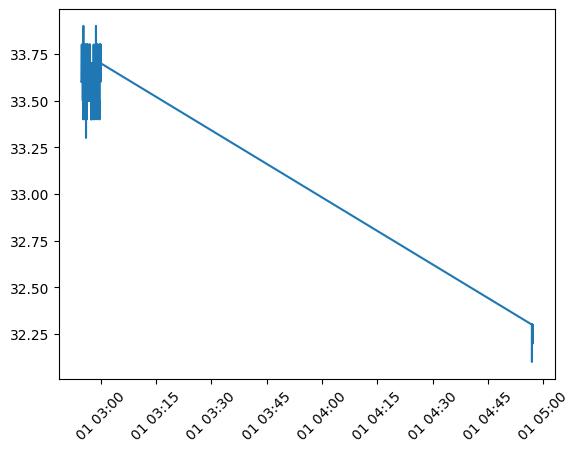

In [8]:
plt.figure()
plt.plot(temps_df['TimeStr'][207200:207850], temps_df['34-2-V-O-O'][207200:207850])
plt.xticks(rotation=45)

In [23]:
threshold = pd.Timedelta(seconds=6)

gaps = []
for i in range(1, len(temps_df)):
    gap_length = temps_df['TimeStr'].iloc[i] - temps_df['TimeStr'].iloc[i-1]
    if gap_length > threshold:
        gaps.append({
            "gap_index": i,
            "gap_length": gap_length,
            "gap_start": temps_df['TimeStr'].iloc[i-1],
            "gap_end": temps_df['TimeStr'].iloc[i]
        })

gaps_df = pd.DataFrame(gaps)

In [24]:
# add a date column based on gap_start (or gap_end, they’re basically the same day)
gaps_df['date'] = gaps_df['gap_start'].dt.date

# longest break per day
longest_breaks = gaps_df.groupby('date')['gap_length'].max()

# number of breaks per day
num_breaks = gaps_df.groupby('date').size()

# total break time per day
total_break_time = gaps_df.groupby('date')['gap_length'].sum()

# combine into one DataFrame
daily_stats = pd.DataFrame({
    "longest_break": longest_breaks,
    "num_breaks": num_breaks,
    "total_break_time": total_break_time
}).reset_index()


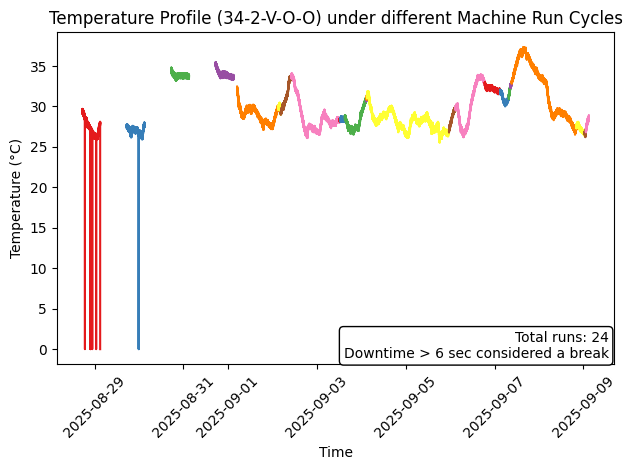

In [25]:
plt.figure()
gap_indices = gaps_df['gap_index'].tolist()

base_colors = [
    "#e41a1c", "#377eb8", "#4daf4a", "#984ea3",
    "#ff7f00", "#ffff33", "#a65628", "#f781bf"
]

for i in range(len(gap_indices)):
    color = base_colors[i % len(base_colors)]
    start = gap_indices[i] + 1
    if i + 1 < len(gap_indices):
        end = gap_indices[i+1]
    else:
        end = len(temps_df)

    x = temps_df.iloc[start:end]['TimeStr']
    y = temps_df.iloc[start:end]['34-2-V-O-O']
    plt.plot(x, y, color=color)

plt.xticks(rotation=45)
plt.xlabel('Time')
plt.title('Temperature Profile (34-2-V-O-O) under different Machine Run Cycles')
plt.ylabel('Temperature (°C)')

# annotation with downtime info
plt.annotate(
    f"Total runs: {len(gap_indices)}\nDowntime > 6 sec considered a break",
    xy=(0.99, 0.01), xycoords="axes fraction",
    ha="right", va="bottom",
    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black")
)

plt.tight_layout()
plt.show()


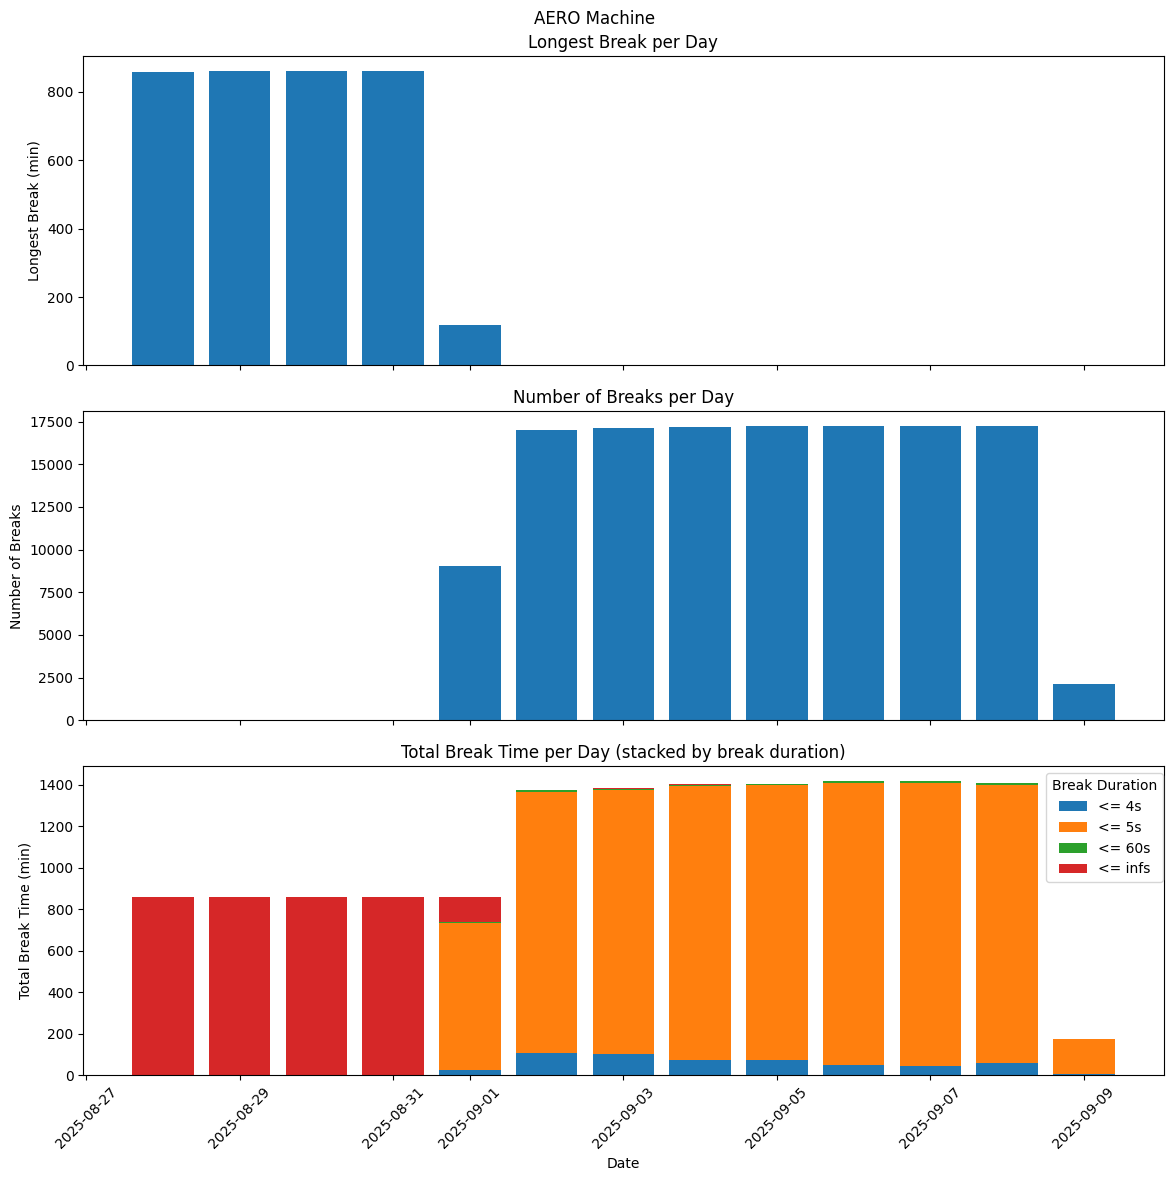

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# convert timedeltas to minutes for easier plotting
daily_stats['longest_break_min'] = daily_stats['longest_break'].dt.total_seconds() / 60
daily_stats['total_break_time_min'] = daily_stats['total_break_time'].dt.total_seconds() / 60

# define thresholds in seconds (including a catch-all for very long breaks)
thresholds = [ 4, 5, 60, np.inf]  # last one for all breaks > 120s
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',]# '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# prepare data for stacked bars (float type)
stacked_breaks = pd.DataFrame(0.0, index=daily_stats['date'], columns=[f"<= {t if t != np.inf else 'inf'}s" for t in thresholds])

for i, t in enumerate(thresholds):
    if i == 0:
        mask = gaps_df['gap_length'].dt.total_seconds() <= t
    else:
        mask = (gaps_df['gap_length'].dt.total_seconds() > thresholds[i-1]) & (gaps_df['gap_length'].dt.total_seconds() <= t)
    tmp = gaps_df[mask].groupby('date')['gap_length'].sum().dt.total_seconds() / 60
    for date, val in tmp.items():
        stacked_breaks.loc[date, f"<= {t if t != np.inf else 'inf'}s"] = val

# plot
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# longest break
axes[0].bar(daily_stats['date'], daily_stats['longest_break_min'])
axes[0].set_ylabel("Longest Break (min)")
axes[0].set_title("Longest Break per Day")

# number of breaks
axes[1].bar(daily_stats['date'], daily_stats['num_breaks'])
axes[1].set_ylabel("Number of Breaks")
axes[1].set_title("Number of Breaks per Day")

# total break time stacked by thresholds
bottom = np.zeros(len(daily_stats))
for i, col in enumerate(stacked_breaks.columns):
    axes[2].bar(daily_stats['date'], stacked_breaks[col], bottom=bottom, color=colors[i], label=col)
    bottom += stacked_breaks[col].values

axes[2].set_ylabel("Total Break Time (min)")
axes[2].set_title("Total Break Time per Day (stacked by break duration)")
axes[2].set_xlabel("Date")
axes[2].legend(title="Break Duration", bbox_to_anchor=(0.885, 1), loc='upper left')
plt.suptitle('AERO Machine')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [34]:
gaps_df

,gap_index,gap_length,gap_start,gap_end,date
0,34689,0 days 14:18:56,2025-08-28 03:00:02,2025-08-28 17:18:58,2025-08-28
1,69374,0 days 14:19:50,2025-08-29 03:00:02,2025-08-29 17:19:52,2025-08-29
2,104009,0 days 14:19:42,2025-08-30 03:00:01,2025-08-30 17:19:43,2025-08-30
3,138642,0 days 14:20:31,2025-08-31 03:00:01,2025-08-31 17:20:32,2025-08-31
4,207818,0 days 01:56:47,2025-09-01 03:00:01,2025-09-01 04:56:48,2025-09-01
5,277924,0 days 00:00:08,2025-09-02 02:59:54,2025-09-02 03:00:02,2025-09-02
6,280234,0 days 00:01:05,2025-09-02 04:31:42,2025-09-02 04:32:47,2025-09-02
7,288928,0 days 00:00:10,2025-09-02 10:16:27,2025-09-02 10:16:37,2025-09-02
8,333010,0 days 00:01:12,2025-09-03 12:20:22,2025-09-03 12:21:34,2025-09-03
9,333620,0 days 00:00:10,2025-09-03 12:43:39,2025-09-03 12:43:49,2025-09-03


In [19]:
extract_features(temps_df, temp_columns)

,Time,cut_short,33-1-Olie_mean,33-1-Olie_median,33-1-Olie_variance,33-1-Olie_skewness,33-1-Olie_kurtosis,33-1-Olie_rolling_mean_3,33-1-Olie_rolling_std_3,33-1-Olie_num_peaks,...,40-8-OMG_num_peaks,40-8-OMG_max_slope,40-8-OMG_heating_rate_max,40-8-OMG_cooling_rate_max,40-8-OMG_duration_above_mean,40-8-OMG_duration_below_mean,40-8-OMG_dominant_freq,40-8-OMG_spectral_energy,40-8-OMG_spectral_centroid,40-8-OMG_spectral_entropy
0,2025-08-27 17:18:58,False,36.324477,36.3,0.384356,-56.160768,3287.988139,36.533333,0.057735,840,...,927,0.7,0.7,-0.7,2126,1457,0.000279,507429.44,0.000000e+00,7.853337
1,2025-08-27 18:18:59,False,36.517974,36.5,0.016902,-0.030666,0.031709,36.766667,0.115470,853,...,879,0.7,0.5,-0.7,1582,2001,0.000279,740563.88,0.000000e+00,7.773076
2,2025-08-27 19:19:00,False,36.614086,36.6,0.389246,-56.402887,3307.530872,36.533333,0.057735,864,...,891,32.4,32.4,-32.4,1783,1802,0.000279,4816144.94,-1.500332e-17,8.140057
3,2025-08-27 20:19:01,False,36.102931,36.1,0.435621,-45.691925,2497.800924,35.666667,0.057735,840,...,837,32.8,32.7,-32.8,1559,2023,0.000279,4202733.56,-1.298300e-04,8.166266
4,2025-08-27 21:19:02,False,35.456529,35.4,0.031780,0.165951,-0.330493,35.333333,0.057735,831,...,823,0.6,0.6,-0.5,1729,1855,0.000279,315471.20,-6.619976e-05,7.901023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2025-09-08 22:10:20,False,35.278776,35.3,0.014399,-0.306908,-0.112465,35.233333,0.115470,195,...,199,0.5,0.5,-0.5,426,342,0.001302,17185.28,-2.983392e-04,6.377553
236,2025-09-08 23:10:25,False,35.347733,35.4,0.013686,-0.403458,0.430672,35.266667,0.057735,203,...,189,0.5,0.5,-0.4,482,268,0.001333,5868.36,-1.255190e-03,6.467628
237,2025-09-09 00:10:30,False,35.399222,35.4,0.013090,-0.557465,0.863944,35.400000,0.000000,194,...,208,0.6,0.6,-0.6,402,369,0.002594,9519.92,0.000000e+00,6.473791
238,2025-09-09 01:10:35,False,35.438349,35.4,0.009807,-0.248073,0.100556,35.566667,0.057735,184,...,209,0.5,0.5,-0.5,286,465,0.001332,7625.58,-1.413773e-17,6.452295


In [50]:
feature_df = extract_features_by_indices(temps_df,temp_columns, gap_indices)
feature_df = feature_df.drop(columns=['segment_start_time', 'segment_end_time', 'segment_start_idx',
       'segment_end_idx',])

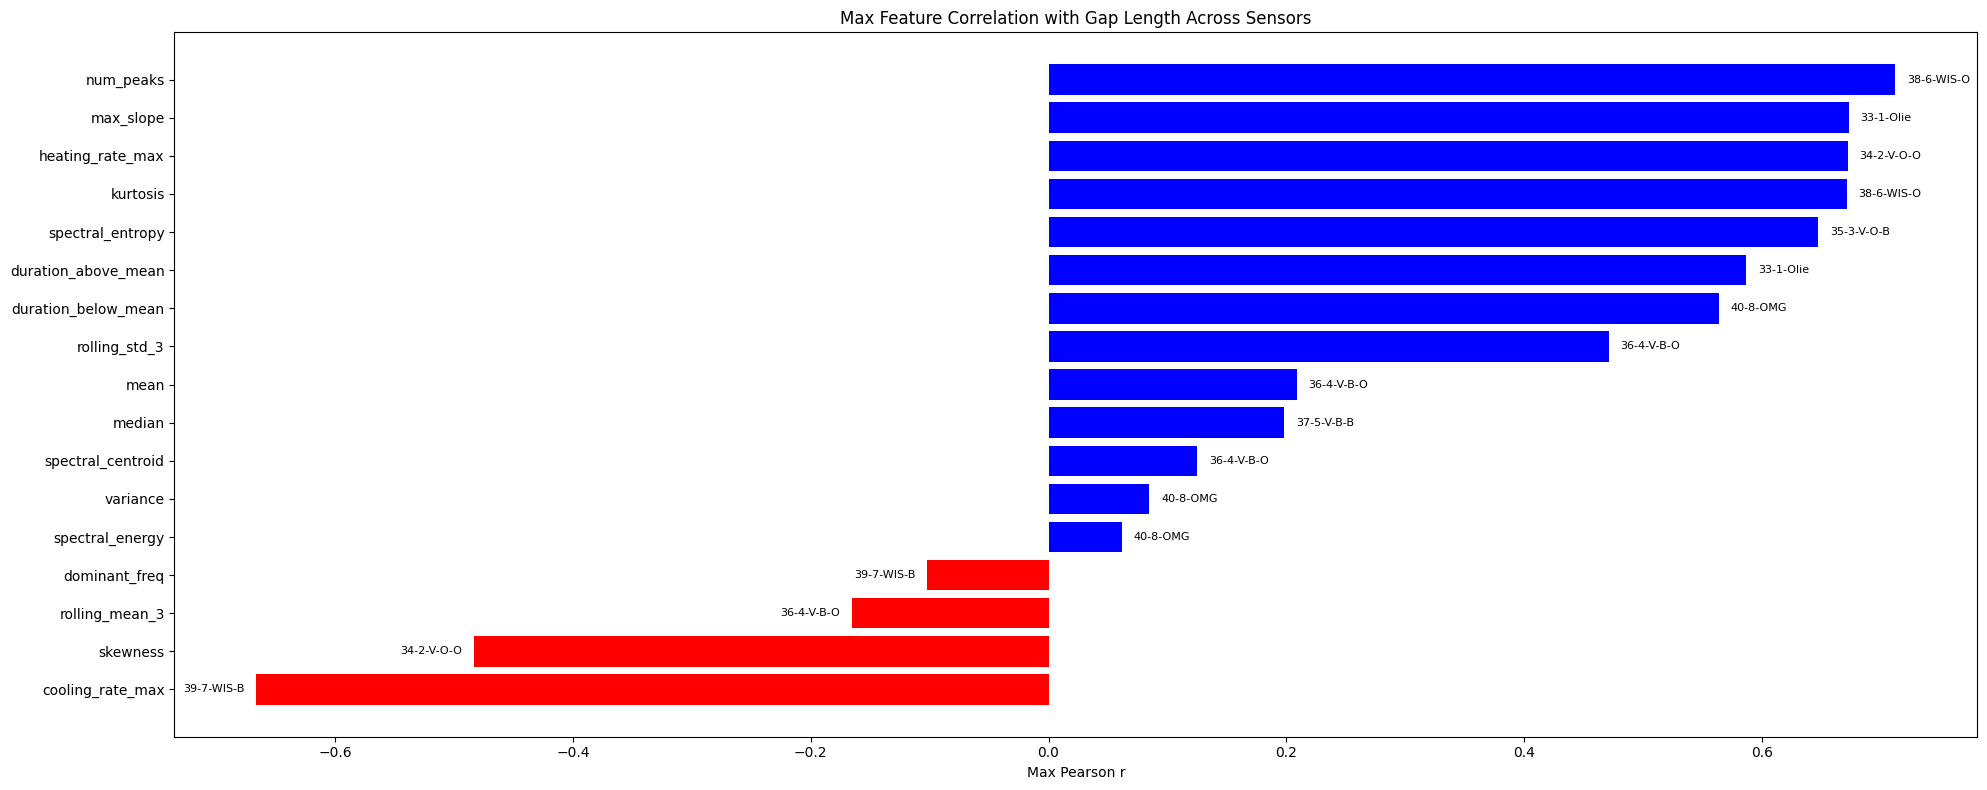

In [ ]:
gaps_numeric = gaps_df['gap_length'].dt.total_seconds()

# Compute correlations
feature_df_copy = feature_df.copy()
feature_df_copy['gap_length'] = gaps_numeric
corr_df = feature_df_copy.corr()['gap_length'].drop('gap_length')

# Extract base feature names and sensor names
sensor_feature_pairs = [(col.split('_', 1)[0], col.split('_', 1)[1]) for col in feature_df.columns]  # (sensor, feature)

# Find max correlation and corresponding sensor for each feature
max_corr_dict = {}
sensor_for_max = {}
for sensor, feature in sensor_feature_pairs:
    if feature not in max_corr_dict or corr_df[sensor + '_' + feature] > max_corr_dict[feature]:
        max_corr_dict[feature] = corr_df[sensor + '_' + feature]
        sensor_for_max[feature] = sensor

# Convert to Series for plotting and sort
max_corr = pd.Series(max_corr_dict).sort_values()
sensors = pd.Series(sensor_for_max)[max_corr.index]

# Plot horizontal heatmap
plt.figure(figsize=(20, 8))
plt.barh(max_corr.index, max_corr.values, color=[(0,0,1) if x>0 else (1,0,0) for x in max_corr.values])
plt.xlabel('Max Pearson r')
plt.title('Max Feature Correlation with Gap Length Across Sensors')

# Annotate which sensor gave max correlation
for i, (val, sensor) in enumerate(zip(max_corr.values, sensors)):
    plt.text(val + 0.01*np.sign(val), i, sensor, va='center', ha='left' if val>0 else 'right', fontsize=8)

plt.tight_layout()
plt.show()


Drive Data

In [6]:
position_a_0_0100_svrm2 = SVRM2_drive_df[['TIME','A-0-0100']][4:]

position_a_0_0100_svrm2['TIME'] = pd.to_numeric(position_a_0_0100_svrm2['TIME'], errors='coerce')
position_a_0_0100_svrm2['A-0-0100'] = pd.to_numeric(position_a_0_0100_svrm2['A-0-0100'], errors='coerce')
position_a_0_0100_svrm2 = position_a_0_0100_svrm2.reset_index(drop=True)

In [7]:
position_a_0_0100_svrm3 = SVRM3_drive_df[['TIME', 'A-0-0100']][4:]
position_a_0_0100_svrm3['TIME'] = pd.to_numeric(position_a_0_0100_svrm3['TIME'], errors='coerce')
position_a_0_0100_svrm3['A-0-0100'] = pd.to_numeric(position_a_0_0100_svrm3['A-0-0100'], errors='coerce')
position_a_0_0100_svrm3 = position_a_0_0100_svrm3.reset_index(drop=True)

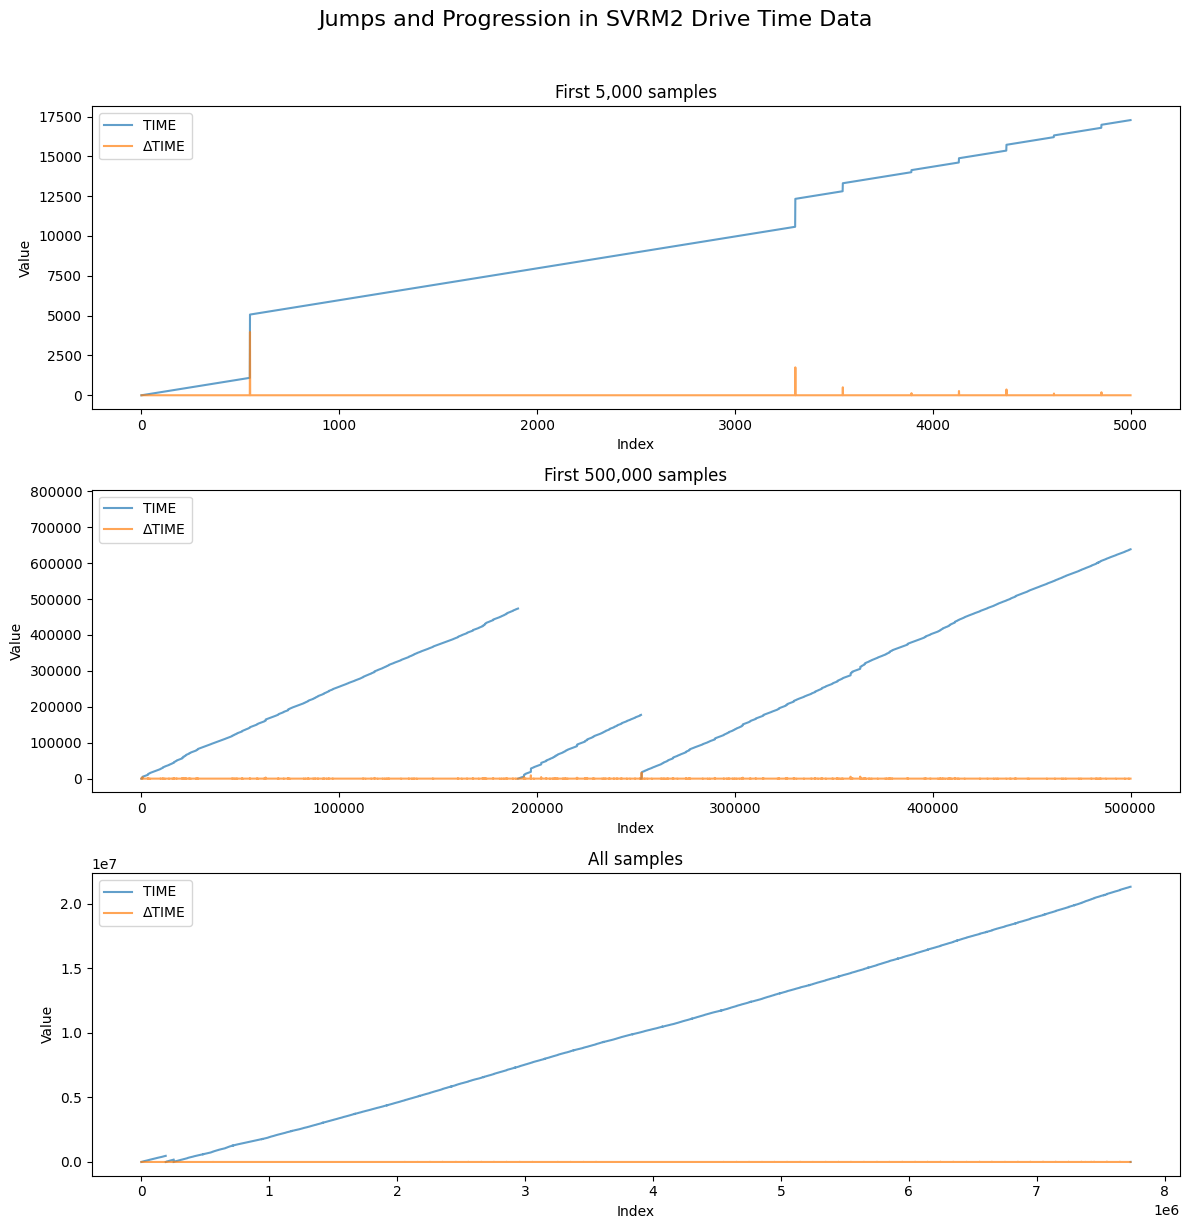

In [7]:
time = position_a_0_0100_svrm2['TIME']

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

slices = [5000, 500000, None]
titles = ["First 5,000 samples", "First 500,000 samples", "All samples"]

for i, (ax, sl, title) in enumerate(zip(axes, slices, titles)):
    t = time[:sl]
    dt = t.diff().dropna()

    ax.plot(t.index, t, label="TIME", alpha=0.7)
    ax.plot(dt.index, dt, label="ΔTIME", alpha=0.7)

    # allow negatives on the 2nd plot
    if i == 1:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin * 1.2, ymax * 1.2)  # expand a bit so negatives show

    ax.set_title(title)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend(loc='upper left')

plt.suptitle("Jumps and Progression in SVRM2 Drive Time Data", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


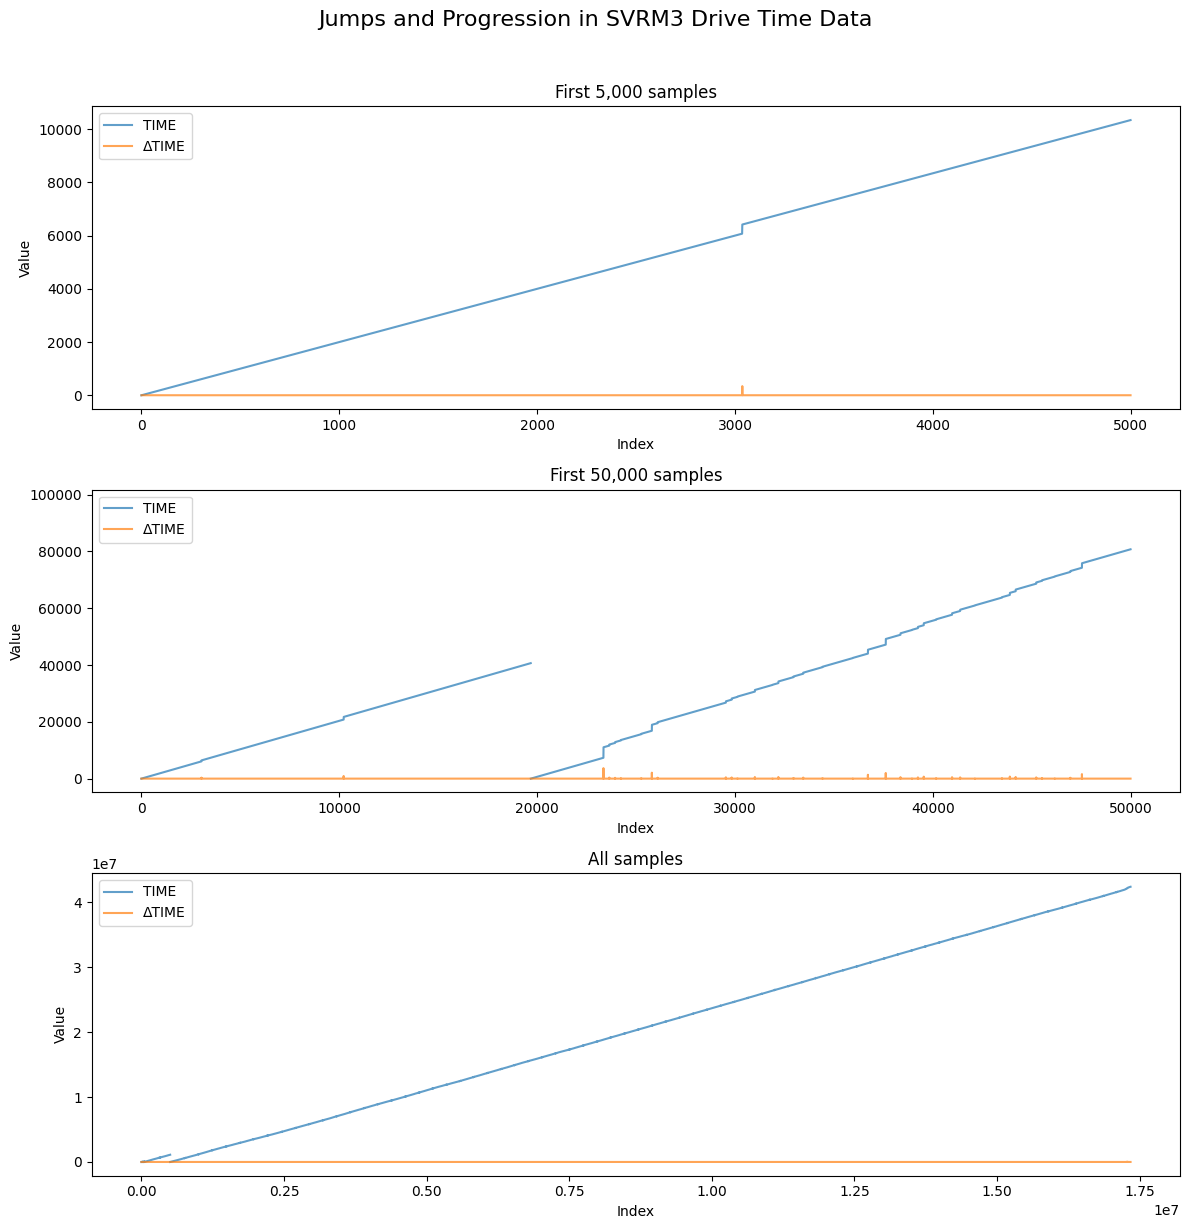

In [8]:
time = position_a_0_0100_svrm3['TIME']

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

slices = [5000, 50000, None]
titles = ["First 5,000 samples", "First 50,000 samples", "All samples"]

for i, (ax, sl, title) in enumerate(zip(axes, slices, titles)):
    t = time[:sl]
    dt = t.diff().dropna()

    ax.plot(t.index, t, label="TIME", alpha=0.7)
    ax.plot(dt.index, dt, label="ΔTIME", alpha=0.7)

    # allow negatives on the 2nd plot
    if i == 1:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin * 1.2, ymax * 1.2)  # expand a bit so negatives show

    ax.set_title(title)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend(loc='upper left')

plt.suptitle("Jumps and Progression in SVRM3 Drive Time Data", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [16]:
named_cols_svrm2 = ['A-0-0100', 'A-0-0102', 'A-0-0110', 'A-0-0100.1', 'A-0-0102.1',
       'A-0-0110.1', 'A-0-0100.2', 'A-0-0102.2', 'A-0-0110.2', 'A-0-0100.3',
       'A-0-0102.3', 'A-0-0110.3', 'A-0-0100.4', 'A-0-0102.4', 'A-0-0110.4',
       'A-0-0100.5', 'A-0-0102.5', 'A-0-0110.5', 'A-0-0100.6', 'A-0-0102.6',
       'A-0-0110.6', 'A-0-0100.7', 'A-0-0102.7', 'A-0-0110.7', 'A-0-0100.8',
       'A-0-0102.8', 'A-0-0110.8', 'A-0-0100.9', 'A-0-0102.9', 'A-0-0110.9',
       'A-0-0100.10', 'A-0-0102.10', 'A-0-0110.10', 'A-0-0100.11',
       'A-0-0102.11', 'A-0-0110.11',]

In [8]:
SVRM2_drive_df_semi_fixed = SVRM2_drive_df[named_cols_svrm2][4:]
for col in named_cols_svrm2:
    SVRM2_drive_df_semi_fixed[col] = pd.to_numeric(SVRM2_drive_df_semi_fixed[col], errors='coerce')

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_svrm2_scaled = pd.DataFrame(scaler.fit_transform(SVRM2_drive_df_semi_fixed), columns=named_cols_svrm2)

In [14]:
subcolumns = list(SVRM2_drive_df[named_cols_svrm2].iloc[1])

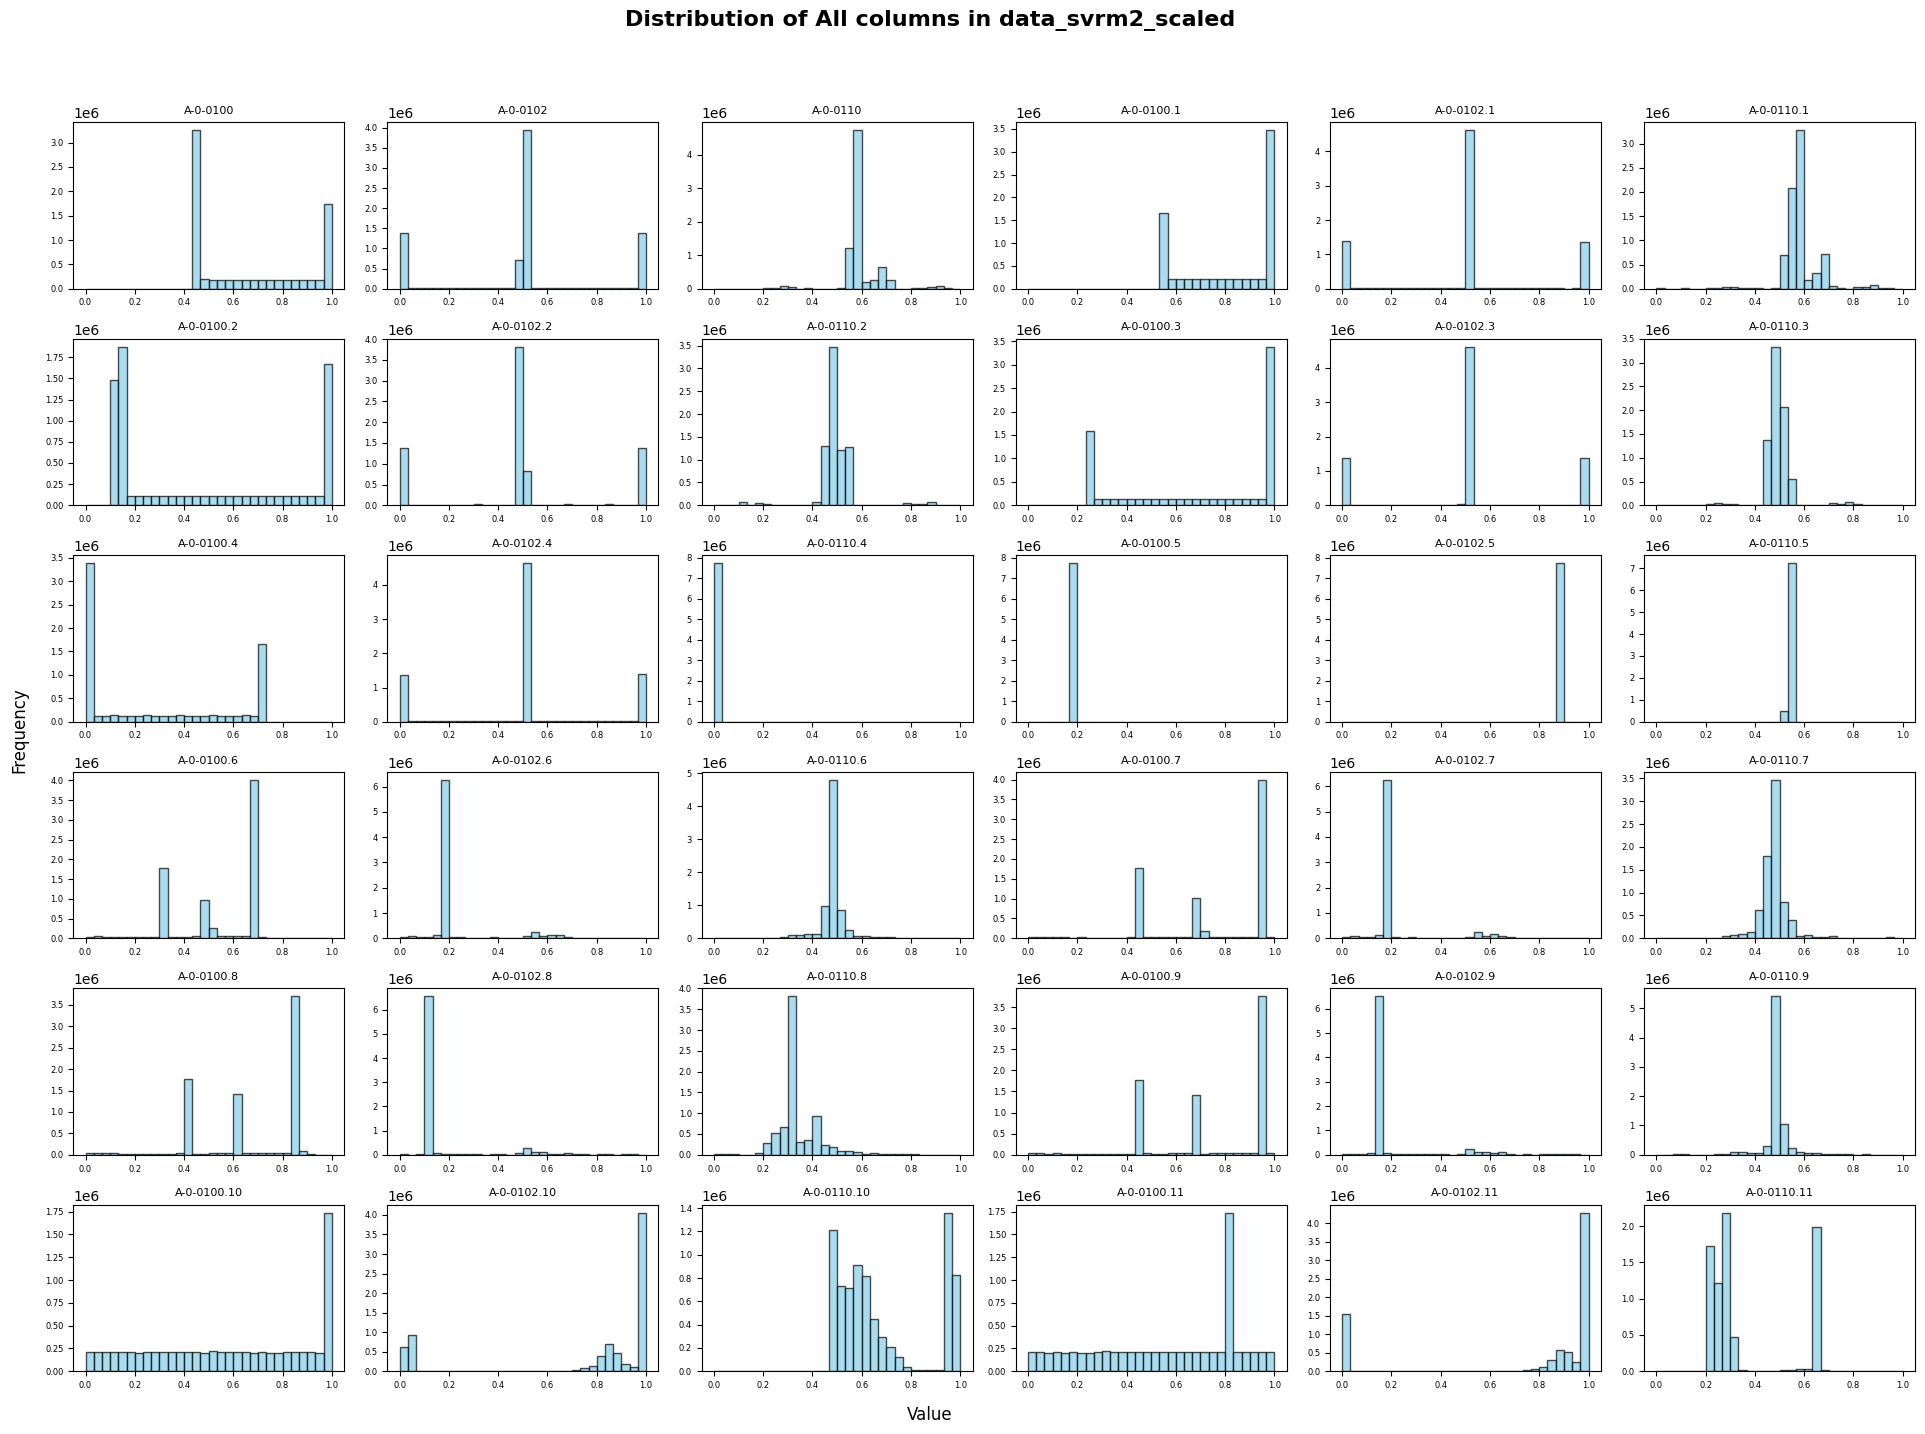

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 6, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(data_svrm2_scaled.columns):
    axes[i].hist(data_svrm2_scaled[col], bins=30, color='skyblue', alpha=0.7)
    axes[i].set_title(col, fontsize=8)
    axes[i].tick_params(axis='x', labelsize=6)
    axes[i].tick_params(axis='y', labelsize=6)

# Common title for the whole figure
fig.suptitle("Distribution of All columns in data_svrm2_scaled", fontsize=16, fontweight="bold")

# Global labels
fig.text(0.5, 0.04, "Value", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Frequency", va="center", rotation="vertical", fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # leave space for title and labels
plt.show()


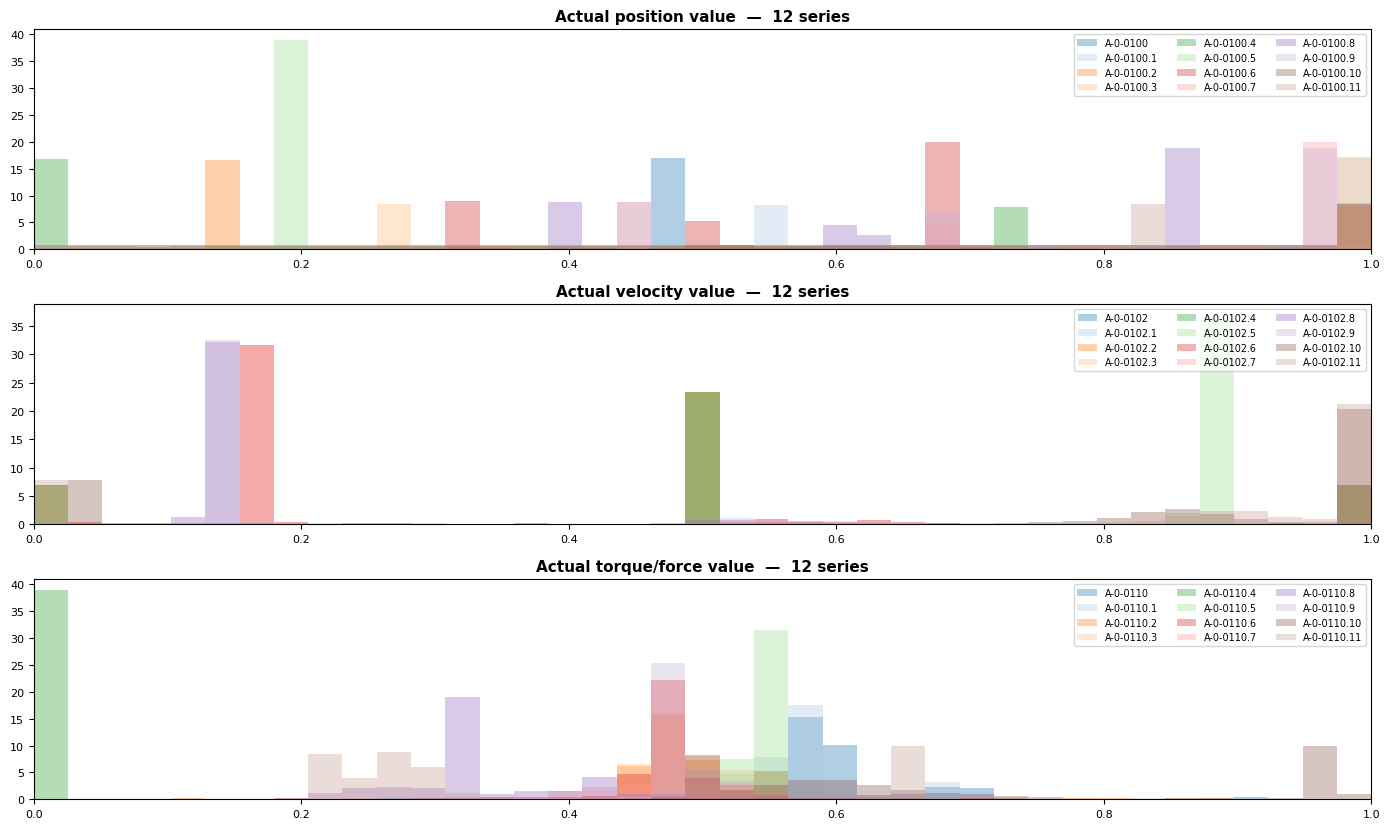

In [17]:
import numpy as np
import matplotlib.pyplot as plt

groups = {}
for col, group_name in zip(named_cols_svrm2, subcolumns):
    groups.setdefault(group_name, []).append(col)

# plotting
num_groups = len(groups)
fig, axes = plt.subplots(num_groups, 1, figsize=(14, 2.8*num_groups), squeeze=False)
axes = axes.flatten()

colors = plt.cm.tab20.colors  # good palette for many categories

for ax, (group_name, cols) in zip(axes, groups.items()):
    gdata = data_svrm2_scaled[cols]
    vmin = float(gdata.min().min())
    vmax = float(gdata.max().max())
    if vmin == vmax:
        vmin -= 0.5
        vmax += 0.5
    bins = np.linspace(vmin, vmax, 40)
    
    for i, col in enumerate(cols):
        ax.hist(
            gdata[col].dropna(),
            bins=bins,
            density=True,
            alpha=0.35,         # semi-transparent fill
            color=colors[i % len(colors)],
            label=col
        )
    ax.set_title(f"{group_name}  —  {len(cols)} series", fontsize=11, weight="bold")
    ax.set_xlim(vmin, vmax)
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    ax.legend(fontsize="x-small", ncol=3, loc="upper right")

plt.tight_layout()
plt.show()


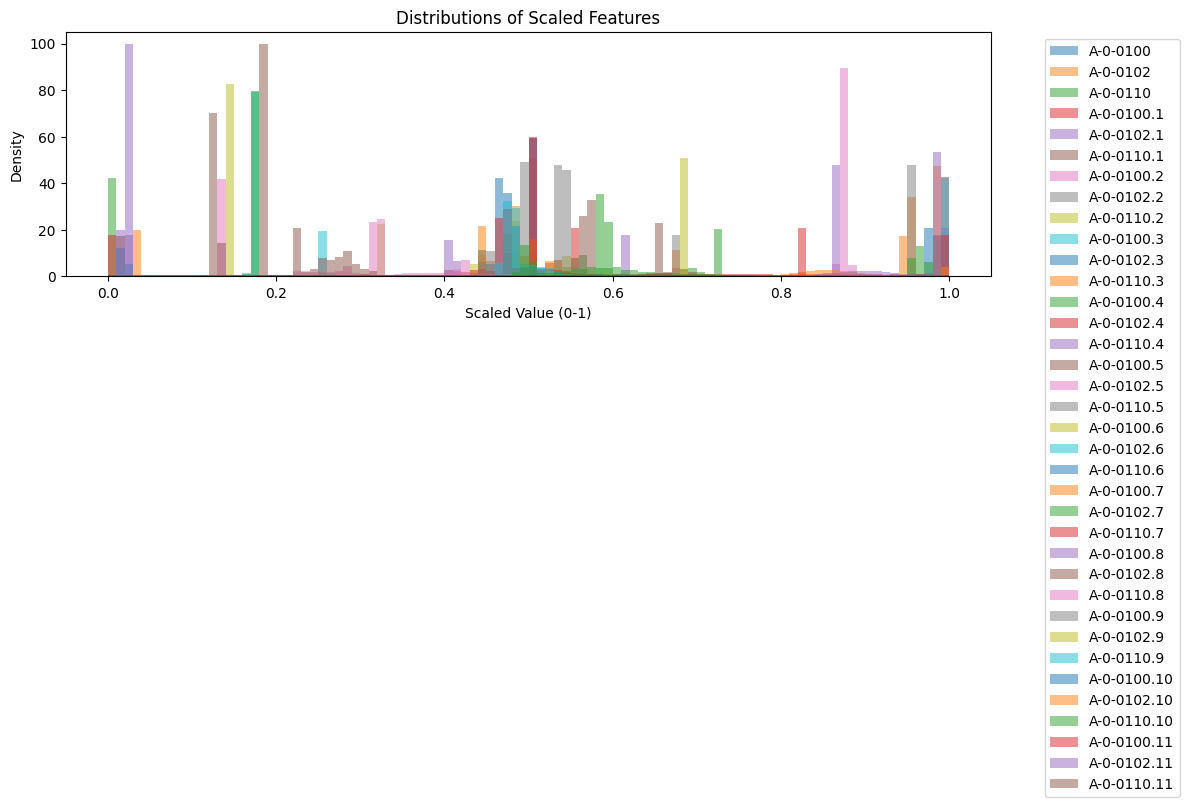

In [29]:
import matplotlib.pyplot as plt

# assume data_scaled is your scaled DataFrame
plt.figure(figsize=(12, 6))

for col in data_svrm2_scaled.columns[:]:
    plt.hist(data_svrm2_scaled[col], bins=100, alpha=0.5, label=col, density=True)

plt.title("Distributions of Scaled Features")
plt.xlabel("Scaled Value (0-1)")
plt.ylabel("Density")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


EWON Data

In [ ]:
SVRM3_ewon_df_length = SVRM3_ewon_df[['TimeStr','Lengte_verduning']]

In [ ]:
SVRM3_ewon_df_length = SVRM3_ewon_df_length.replace(["Undef", np.nan, None], np.nan)
SVRM3_ewon_df_length['TimeStr'] = pd.to_datetime(SVRM3_ewon_df_length['TimeStr'], errors='coerce')
SVRM3_ewon_df_length = SVRM3_ewon_df_length.sort_values('TimeStr')
SVRM3_ewon_df_length = SVRM3_ewon_df_length.iloc[1:]
ewon_columns = ['Lengte_verduning']
SVRM3_ewon_df_length[ewon_columns] = SVRM3_ewon_df_length[ewon_columns].astype(float)
SVRM3_ewon_df_length = SVRM3_ewon_df_length.dropna(subset=ewon_columns)
SVRM3_ewon_df_length = SVRM3_ewon_df_length.reset_index(drop=True)


(array([20156., 20160., 20164., 20168., 20172., 20176., 20179., 20183.,
        20187.]),
 [Text(20156.0, 0, '2025-03-09'),
  Text(20160.0, 0, '2025-03-13'),
  Text(20164.0, 0, '2025-03-17'),
  Text(20168.0, 0, '2025-03-21'),
  Text(20172.0, 0, '2025-03-25'),
  Text(20176.0, 0, '2025-03-29'),
  Text(20179.0, 0, '2025-04-01'),
  Text(20183.0, 0, '2025-04-05'),
  Text(20187.0, 0, '2025-04-09')])

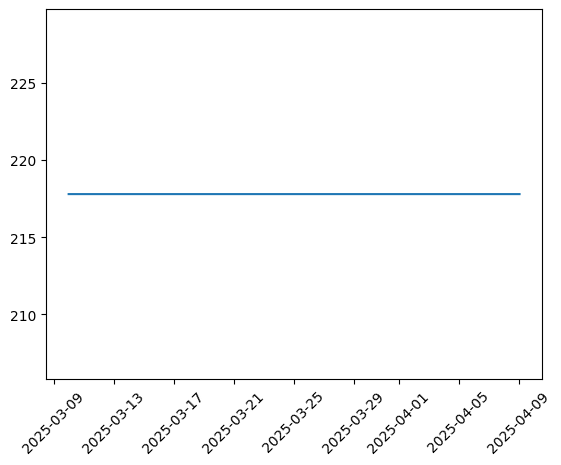

In [97]:
plt.plot(SVRM3_ewon_df_length['TimeStr'][33000:36000], SVRM3_ewon_df_length['Lengte_verduning'][33000:36000])
plt.xticks(rotation=45)

In [84]:
len(SVRM3_ewon_df_length) / 2

33980.0

Text(0.5, 0, 'Time')

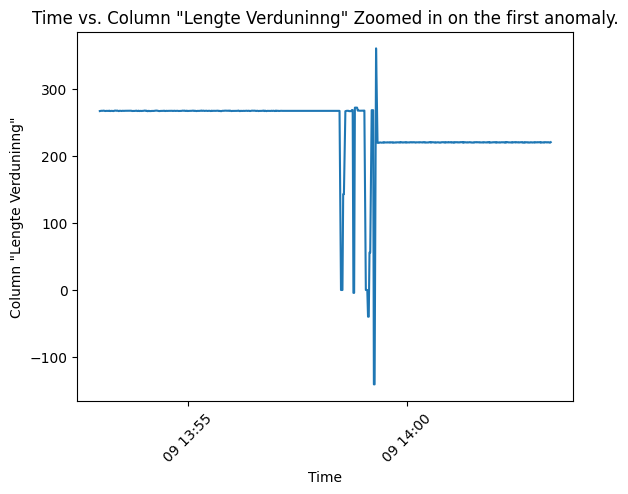

In [100]:
plt.plot(SVRM3_ewon_df_length['TimeStr'][7000:7500], SVRM3_ewon_df_length['Lengte_verduning'][7000:7500])
plt.xticks(rotation=45)
plt.title('Time vs. Column "Lengte Verduninng" Zoomed in on the first anomaly.')
plt.ylabel('Column "Lengte Verduninng"')
plt.xlabel('Time')